In [16]:
#%matplotlib inline
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm             ### displays progress
from numpy import sin, cos, sqrt, array, linspace

\begin{equation} \label{eq:Heff_c} 
     \hat{H}^{eff}_{OptoMech}=-(\Delta +\frac{g^2_{ac}}{\Delta_{al}} ) \hat{a}^{\dagger} \hat{a} + \omega_m \hat{b}^{\dagger} \hat{b} + \alpha (\hat{b}+\hat{b}^{\dagger}) - g_{eff} \hat{a}^{\dagger}\hat{a}(\hat{b}+\hat{b}^{\dagger}) - iF_L (\hat{a}^\dagger-\hat{a} )
\end{equation}

$$
\alpha = g_{am} (1-\frac{g_{ac}^2}{\Delta_{aL}^2}) , ~~~~~ g_{eff} = g_{cm} + 2 \frac{g_{am}g_{ac}^2}{\Delta_{aL}^2}
$$

$$
\Delta = \omega_L - \omega_c     , ~~~~~ \Delta_{aL}= \omega_a - \omega_L
$$

#### Displaced $H_{D}^{eff}$ 
$
\hat{b}_n = \hat{b} + \alpha/\omega_m
$

$
\hat{b}^{\dagger}_n = \hat{b}^{\dagger} + \alpha/\omega_m
$

\begin{equation} \label{eq:Heff_c2} 
     \hat{H}^{eff}_{D}=-(\Delta +\frac{g^2_{ac}}{\Delta_{aL}} - \frac{2 \alpha g_{eff}}{\omega_m} ) \hat{a}^{\dagger} \hat{a} + 
     \omega_m \hat{b}_n^{\dagger} \hat{b}_n  - g_{eff} \hat{a}^{\dagger}\hat{a}(\hat{b}_n+\hat{b}^{\dagger}_n) - iF_L (\hat{a}^\dagger-\hat{a} )
\end{equation}

In [2]:
def mean_steady1a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L):
    N = 5 #5                  # number of cavity fock states
    M = 9 #9                  # number of phonon fock states  
    
    #alpha = g_am * (1-(g_ac/Delta_aL)**2)
    alpha = - (g_eff-g_cm)/2.
    
    a = tensor(destroy(N), qeye(M))  # , qeye(2)
    b = tensor(qeye(N), destroy(M))
    #sigma_z = tensor(qeye(N), qeye(M)) # , sigmaz() , , sigmap() , sigmam()
    #sigma_p = tensor(qeye(N), qeye(M))  # raising and lowering ops for atom
    #sigma_m = tensor(qeye(N), qeye(M))
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = gamma
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    #rate = gamma_a
    #if rate > 0.0 : 
    #    c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(w_cLlist))
    #####
    for w_c in w_cLlist:    
        
        Heff_Cav  = -(w_L -w_c + (g_ac**2)/Delta_aL) * num_a # + (2* alpha * g_cm/w_m) * num_a
        Heff_Mech =  w_m * num_b + alpha * (b.dag() + b) # 
        #### Interaction  Hamiltonian
        Heff_Int  =  - g_eff * num_a *(b + b.dag())
        # Laser drive 
        H_drive   =  1j* F_L *(a.dag()-a)   
        ### constant value 
        #H_0 = - 0.5 * Delta_aL - (g_ac**2)/(2*Delta_aL)               ## 
        ##### Total H: 
        H =   Heff_Cav + Heff_Mech + Heff_Int + H_drive   #+ H_0
        #########################
        ########################
        # <n>
        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-14) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)
      
        idx +=1

    H0 =  w_m * num_b + H_drive   # H0 at resonance and g=0
    return  n, c_ops, a, H0

### Parameters 

In [20]:
Set = 3               ##### set of Parametrs    

if (Set==1):
    w_a  = 105      #[ 1500 ]   [1052  ]
    w_L  =  100 
    g_am = 0.5         #[  50   ]  [.54    ] 
    g_ac =  5   
elif Set==2:
    w_a  = 10520      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 0.54      #[  50   ]   [.54     ]
    g_ac =  500
elif Set==3: 
    w_a  = 15000      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  500   

w_m  = 1                       # mechanical frequency
n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.0001 * w_m               # cavity-resonator couplng  10 ^-5
Delta_aL = w_a - w_L
shift = g_ac**2/Delta_aL
shift
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
g_eff*(g_eff-g_cm)

1.0001000000000004

## Display Figures 

100%|██████████| 4/4 [01:02<00:00, 15.65s/it]


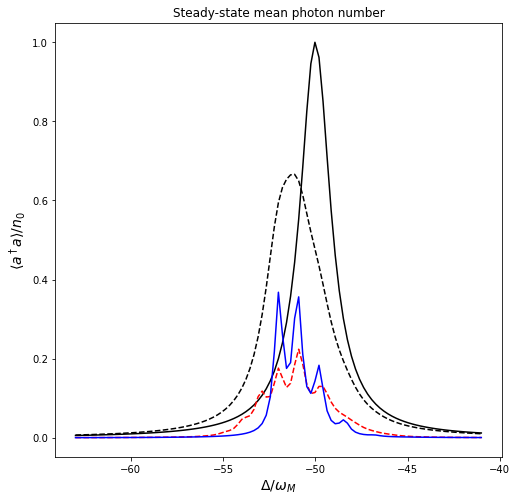

In [14]:
tlist = np.linspace(0, 100.0, 800)                   # Time evolution
fig, ax= plt.subplots(1,1,figsize=(8,8))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']


minn_c = w_L +shift + 13 #  w_L - 37 # + shift + 6  #
maxx_c = w_L +shift - 9  #  w_L - 59 #+ shift - 6 #
w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 101)    # 151 is spacing samples
g_ef = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
#### to save data
xplot = []                                 #######=====###########====####
pllot1a  = np.zeros((len(w_cLlist),4))       ############tlist
#pllot4aa  = np.zeros((len(w_cLlist),4))       ############wlist
g_eff_i = [0, g_ef,g_ef,g_ef]

for i in tqdm([ 0, 1, 2, 3]): #[0, 1, 2, 3]:
    g_eff= g_eff_i[i]
    kappa = kappa_i[i]
    n_th            = n_th_i[i]
    F_L   = sqrt(kappa) * 0.01        # 
    n, c_ops, a, H0 = mean_steady1a(w_m, w_L, w_a, Delta_aL, w_cLlist, g_ac, g_cm, g_am,g_eff, n_th, kappa, gamma, F_L)    
    solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
    # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
    use_rcm = False
    #rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)
    #n_0 = expect(a.dag()*a,rho0) 
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
      ######################################################
    ax.plot((w_L - w_cLlist)/w_m , n/n_0, linestyle =linestyle[i], color=color[i]) # + shift
    
    xplot = (w_L - w_cLlist)/w_m #+ shift
    pllot1a[: , i] = n/n_0
#######
ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Steady-state mean photon number')
        
#######        
plt.savefig("SteaSt_MeanPhoton_Modi_1a_15000.pdf") # , dpi=50
plt.show()

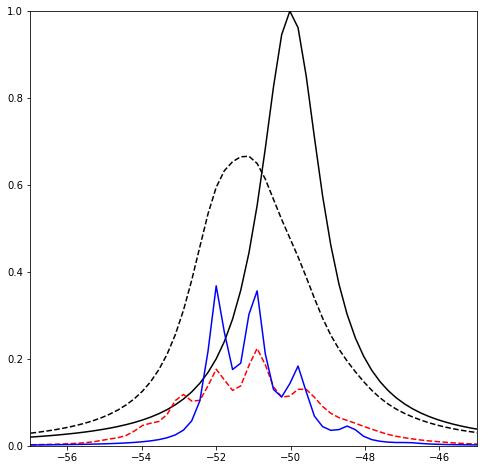

In [15]:

data1a = np.column_stack([xplot, pllot1a[: , 0],pllot1a[: , 1] ,pllot1a[: , 2], pllot1a[: , 3]])
np.savetxt("Fig1a15000Modf.txt" , data1a, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-.','-','--','--','-']
color=['t','black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(8,8))
for i in [1,2,3,4]:
    plt.plot(xplot, data1a[:,i], linestyle = linestyle[i], color = color[i])
    
ax.set_xlim([-57,-45])
ax.set_ylim([0,1])
plt.savefig("SteaSt_MeanPhoton_Modi_1a_15000.pdf")
plt.show()

